In [18]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 1. 데이터 로드 및 기본 정보 확인

In [9]:
# 데이터 로드
df = pd.read_csv('chi_square_data_6-20.csv')

In [14]:
# 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(f"\n데이터 크기: {df.shape}")
print(f"총 관측치: {len(df):,}개")

print("\n컬럼 정보:")
print(df.info())

print("\n첫 10개 행 확인:")
display(df.head(10))

print("\n각 컬럼의 고유값 확인:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count}개 고유값")
    if unique_count < 10: # 고유값이 10개 미만인 경우 상세 확인
        print(f"  - 고유값 상세: {df[col].unique()}")

=== 데이터 기본 정보 ===

데이터 크기: (900000, 4)
총 관측치: 900,000개

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   stage       900000 non-null  object
 1   passed      900000 non-null  int64 
 2   user_id     900000 non-null  int64 
 3   group_type  900000 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.5+ MB
None

첫 10개 행 확인:


,stage,passed,user_id,group_type
0,6-20,1,527985,최적의 조합
1,6-20,1,618094,최적의 조합
2,6-20,1,484218,최적의 조합
3,6-20,1,161124,최적의 조합
4,6-20,1,718643,비효율적 조합
5,6-20,1,234836,최적의 조합
6,6-20,0,484014,비효율적 조합
7,6-20,1,555954,최적의 조합
8,6-20,0,282984,준최적 조합
9,6-20,1,619022,최적의 조합



각 컬럼의 고유값 확인:
stage: 1개 고유값
  - 고유값 상세: ['6-20']
passed: 2개 고유값
  - 고유값 상세: [1 0]
user_id: 900000개 고유값
group_type: 3개 고유값
  - 고유값 상세: ['최적의 조합' '비효율적 조합' '준최적 조합']


### 2. 데이터 품질 검증 및 전처리
90만 개 데이터 완정성 검증

In [15]:
def validate_and_clean_data(df):
    """데이터 품질 검증 및 정제"""
    
    print("=== 데이터 품질 검증 ===")
    
    # 결측값 확인
    missing_info = df.isnull().sum()
    print("결측값 현황:")
    print(missing_info)
    
    if missing_info.sum() > 0:
        print("⚠️ 결측값 발견. 해당 행을 제거합니다.")
        df_clean = df.dropna()
        print(f"결측값 제거 후 데이터 크기: {df_clean.shape}")
    else:
        print("✅ 결측값이 없습니다.")
        df_clean = df.copy()
    
    # 중복 user_id 확인 (각 유저는 고유해야 함)
    duplicate_users = df_clean[df_clean.duplicated(subset=['user_id'])]
    if len(duplicate_users) > 0:
        print(f"⚠️ 중복 user_id 발견: {len(duplicate_users):,}개")
        print("첫 번째 기록만 유지합니다.")
        df_clean = df_clean.drop_duplicates(subset=['user_id'], keep='first')
        print(f"중복 제거 후 데이터 크기: {df_clean.shape}")
    else:
        print("✅ 중복 user_id가 없습니다.")
    
    # 변수 값 범위 확인
    print(f"\n=== 변수 분포 확인 ===")
    print(f"stage 범위: {df_clean['stage'].unique()}")
    print(f"passed 값: {df_clean['passed'].unique()}")
    print(f"group_type 범주: {df_clean['group_type'].unique()}")
    
    # passed 값이 0, 1인지 확인
    if not set(df_clean['passed'].unique()).issubset({0, 1}):
        print("❌ passed 컬럼이 0, 1 값만 포함하지 않습니다.")
        return None
    
    return df_clean

# 데이터 검증 및 정제
df_clean = validate_and_clean_data(df)

if df_clean is None:
    print("데이터 검증 실패. 데이터를 다시 확인해주세요.")
else:
    print(f"✅ 최종 분석 데이터: {len(df_clean):,}개 행")


=== 데이터 품질 검증 ===
결측값 현황:
stage         0
passed        0
user_id       0
group_type    0
dtype: int64
✅ 결측값이 없습니다.
✅ 중복 user_id가 없습니다.

=== 변수 분포 확인 ===
stage 범위: ['6-20']
passed 값: [1 0]
group_type 범주: ['최적의 조합' '비효율적 조합' '준최적 조합']
✅ 최종 분석 데이터: 900,000개 행


### 3. EDA
조합별 통과율 차이 확인

In [16]:
def exploratory_analysis(df):
    """탐색적 데이터 분석"""
    
    print("=== 탐색적 데이터 분석 ===")
    
    # 기본 교차표 생성
    crosstab = pd.crosstab(df['group_type'], df['passed'], margins=True)
    print("교차표 (관측 빈도):")
    print(crosstab)
    
    # 조합별 통과율 계산
    pass_rates = df.groupby('group_type')['passed'].agg(['count', 'sum', 'mean'])
    pass_rates.columns = ['총_사용자수', '통과자수', '통과율']
    pass_rates['이탈자수'] = pass_rates['총_사용자수'] - pass_rates['통과자수']
    pass_rates['이탈율'] = 1 - pass_rates['통과율']
    
    print(f"\n조합별 상세 통계:")
    for group in pass_rates.index:
        stats = pass_rates.loc[group]
        print(f"{group}:")
        print(f"  총 사용자: {stats['총_사용자수']:,}명")
        print(f"  통과자: {stats['통과자수']:,}명 ({stats['통과율']:.1%})")
        print(f"  이탈자: {stats['이탈자수']:,}명 ({stats['이탈율']:.1%})")
    
    # 전체 통과율
    overall_pass_rate = df['passed'].mean()
    print(f"\n전체 통과율: {overall_pass_rate:.1%}")
    print(f"전체 이탈율: {1-overall_pass_rate:.1%}")
    
    return crosstab, pass_rates

# 탐색적 분석 수행
crosstab, pass_rates = exploratory_analysis(df_clean)


=== 탐색적 데이터 분석 ===
교차표 (관측 빈도):
passed           0       1     All
group_type                        
비효율적 조합     149782   55292  205074
준최적 조합       66280  176527  242807
최적의 조합       25793  426326  452119
All         241855  658145  900000

조합별 상세 통계:
비효율적 조합:
  총 사용자: 205,074.0명
  통과자: 55,292.0명 (27.0%)
  이탈자: 149,782.0명 (73.0%)
준최적 조합:
  총 사용자: 242,807.0명
  통과자: 176,527.0명 (72.7%)
  이탈자: 66,280.0명 (27.3%)
최적의 조합:
  총 사용자: 452,119.0명
  통과자: 426,326.0명 (94.3%)
  이탈자: 25,793.0명 (5.7%)

전체 통과율: 73.1%
전체 이탈율: 26.9%


### 4. 시각화

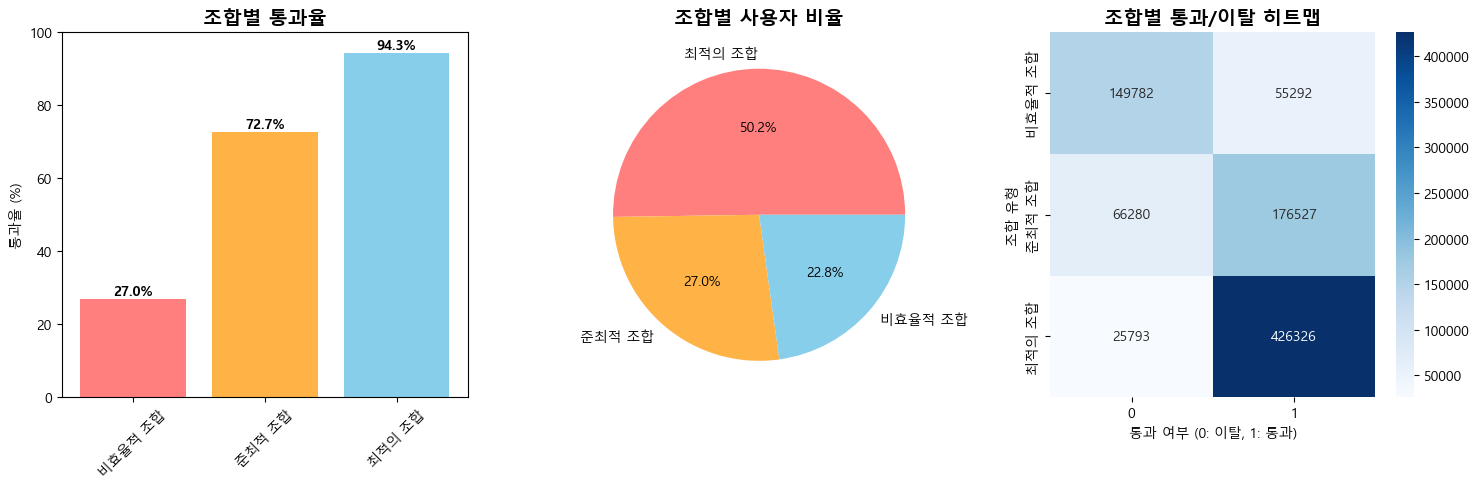

In [19]:
def create_visualizations(df, pass_rates):
    """주요 결과 시각화"""
    
    plt.figure(figsize=(15, 5))
    
    # 1. 조합별 통과율 막대그래프
    plt.subplot(1, 3, 1)
    groups = pass_rates.index
    pass_rate_pct = pass_rates['통과율'] * 100
    bars = plt.bar(groups, pass_rate_pct, color=['#ff7f7f', '#ffb347', '#87ceeb'])
    plt.title('조합별 통과율', fontsize=14, fontweight='bold')
    plt.ylabel('통과율 (%)')
    plt.ylim(0, 100)
    
    # 막대 위에 수치 표시
    for bar, rate in zip(bars, pass_rate_pct):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', fontweight='bold')
    
    plt.xticks(rotation=45)
    
    # 2. 조합별 사용자 분포 파이차트
    plt.subplot(1, 3, 2)
    group_counts = df['group_type'].value_counts()
    plt.pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%',
            colors=['#ff7f7f', '#ffb347', '#87ceeb'])
    plt.title('조합별 사용자 비율', fontsize=14, fontweight='bold')
    
    # 3. 히트맵
    plt.subplot(1, 3, 3)
    crosstab_for_heatmap = pd.crosstab(df['group_type'], df['passed'])
    sns.heatmap(crosstab_for_heatmap, annot=True, fmt='d', cmap='Blues')
    plt.title('조합별 통과/이탈 히트맵', fontsize=14, fontweight='bold')
    plt.xlabel('통과 여부 (0: 이탈, 1: 통과)')
    plt.ylabel('조합 유형')
    
    plt.tight_layout()
    plt.show()

# 시각화 생성
create_visualizations(df_clean, pass_rates)


### 5. 카이제곱 검정 가정 확인

In [20]:
def check_chi_square_assumptions(crosstab):
    """카이제곱 검정 가정 확인"""
    
    print("=== 카이제곱 검정 가정 확인 ===")
    
    # 교차표에서 margin 제거 (All 행/열 제거)
    observed = crosstab.iloc[:-1, :-1]  # 마지막 행과 열(All) 제거
    
    # 기대빈도 계산
    chi2, p, dof, expected = chi2_contingency(observed)
    
    print("관측 빈도표:")
    print(observed)
    
    expected_df = pd.DataFrame(expected, 
                              index=observed.index, 
                              columns=observed.columns)
    print(f"\n기대 빈도표:")
    print(expected_df.round(2))
    
    # 가정 확인
    print(f"\n✅ 가정 1 - 관측치의 독립성:")
    print(f"   각 user_id는 고유하므로 독립성 가정 충족")
    
    print(f"\n✅ 가정 2 - 기대빈도 조건:")
    min_expected = expected.min()
    cells_below_5 = (expected < 5).sum()
    total_cells = expected.size
    
    print(f"   최소 기대빈도: {min_expected:.2f}")
    print(f"   기대빈도 5 미만인 셀: {cells_below_5}/{total_cells}")
    
    if min_expected >= 5:
        print("   ✅ 모든 셀의 기대빈도가 5 이상입니다.")
        assumption_met = True
    else:
        print("   ❌ 일부 셀의 기대빈도가 5 미만입니다.")
        assumption_met = False
    
    print(f"\n✅ 가정 3 - 표본 크기:")
    print(f"   총 표본: {observed.sum().sum():,}개 (충분함)")
    
    return observed, expected_df, assumption_met

# 가정 확인
observed, expected_df, assumptions_met = check_chi_square_assumptions(crosstab)


=== 카이제곱 검정 가정 확인 ===
관측 빈도표:
passed           0       1
group_type                
비효율적 조합     149782   55292
준최적 조합       66280  176527
최적의 조합       25793  426326

기대 빈도표:
passed              0          1
group_type                      
비효율적 조합      55109.08  149964.92
준최적 조합       65248.99  177558.01
최적의 조합      121496.93  330622.07

✅ 가정 1 - 관측치의 독립성:
   각 user_id는 고유하므로 독립성 가정 충족

✅ 가정 2 - 기대빈도 조건:
   최소 기대빈도: 55109.08
   기대빈도 5 미만인 셀: 0/6
   ✅ 모든 셀의 기대빈도가 5 이상입니다.

✅ 가정 3 - 표본 크기:
   총 표본: 900,000개 (충분함)


### 6. 카이제곱 독립성 검정 수행
카이제곱 검정을 통한 연관성 존재 확인

In [21]:
def perform_chi_square_test(observed):
    """카이제곱 독립성 검정 수행"""
    
    print("=== 카이제곱 독립성 검정 결과 ===")
    
    # 카이제곱 검정 수행
    chi2_stat, p_value, dof, expected = chi2_contingency(observed)
    
    print(f"카이제곱 통계량 (χ²): {chi2_stat:.6f}")
    print(f"자유도 (df): {dof}")
    print(f"p-value: {p_value:.2e}")
    
    # 임계값 계산
    from scipy.stats import chi2
    alpha = 0.05
    critical_value = chi2.ppf(1 - alpha, dof)
    print(f"임계값 (α=0.05): {critical_value:.6f}")
    
    # 검정 결과 해석
    print(f"\n=== 검정 결과 해석 ===")
    if p_value < alpha:
        print(f"✅ p-value ({p_value:.2e}) < α ({alpha})")
        print(f"✅ χ² 통계량 ({chi2_stat:.6f}) > 임계값 ({critical_value:.6f})")
        print("📊 결론: 귀무가설을 기각합니다.")
        print("   → 조합 유형과 통과/이탈 간에 통계적으로 유의한 연관성이 있습니다.")
        print("   → 카운터 조합에 대한 이해 부족이 이탈률과 관련이 있을 가능성이 높습니다.")
        significant = True
    else:
        print(f"❌ p-value ({p_value:.6f}) ≥ α ({alpha})")
        print("📊 결론: 귀무가설을 기각할 수 없습니다.")
        print("   → 조합 유형과 통과/이탈 간에 통계적으로 유의한 연관성이 없습니다.")
        significant = False
    
    return chi2_stat, p_value, dof, significant

# 검정 수행
if assumptions_met:
    chi2_stat, p_value, dof, significant = perform_chi_square_test(observed)
else:
    print("⚠️ 통계적 가정이 충족되지 않아 검정 결과의 신뢰성이 낮을 수 있습니다.")
    chi2_stat, p_value, dof, significant = perform_chi_square_test(observed)


=== 카이제곱 독립성 검정 결과 ===
카이제곱 통계량 (χ²): 325519.391834
자유도 (df): 2
p-value: 0.00e+00
임계값 (α=0.05): 5.991465

=== 검정 결과 해석 ===
✅ p-value (0.00e+00) < α (0.05)
✅ χ² 통계량 (325519.391834) > 임계값 (5.991465)
📊 결론: 귀무가설을 기각합니다.
   → 조합 유형과 통과/이탈 간에 통계적으로 유의한 연관성이 있습니다.
   → 카운터 조합에 대한 이해 부족이 이탈률과 관련이 있을 가능성이 높습니다.


### 7. 효과 크기 계산
연관성의 실질적 의미 평가

In [22]:
def calculate_effect_size(chi2_stat, observed):
    """효과 크기 (Cramér's V) 계산"""
    
    print("=== 효과 크기 분석 ===")
    
    n = observed.sum().sum()  # 총 관측치 수
    min_dim = min(observed.shape) - 1  # min(행-1, 열-1)
    
    # Cramér's V 계산
    cramers_v = np.sqrt(chi2_stat / (n * min_dim))
    
    print(f"Cramér's V: {cramers_v:.4f}")
    
    # 효과 크기 해석
    if cramers_v < 0.1:
        effect_interpretation = "작은 효과"
    elif cramers_v < 0.3:
        effect_interpretation = "중간 효과"
    elif cramers_v < 0.5:
        effect_interpretation = "큰 효과"
    else:
        effect_interpretation = "매우 큰 효과"
    
    print(f"효과 크기 해석: {effect_interpretation}")
    
    # 표준화 잔차 계산 (어떤 셀이 특히 기여하는지 확인)
    chi2, p, dof, expected = chi2_contingency(observed)
    std_residuals = (observed - expected) / np.sqrt(expected)
    
    print(f"\n표준화 잔차 (|값| > 2이면 유의한 차이):")
    print(std_residuals.round(3))
    
    return cramers_v, effect_interpretation

# 효과 크기 계산
if 'chi2_stat' in locals():
    cramers_v, effect_interpretation = calculate_effect_size(chi2_stat, observed)


=== 효과 크기 분석 ===
Cramér's V: 0.6014
효과 크기 해석: 매우 큰 효과

표준화 잔차 (|값| > 2이면 유의한 차이):
passed            0        1
group_type                  
비효율적 조합     403.287 -244.473
준최적 조합        4.036   -2.447
최적의 조합     -274.566  166.442


### 8. 종합 결과 정리

🔍 분석 개요:
- 분석 대상: 게임 단계 6-20의 이탈률 분석
- 총 분석 데이터: 900,000명의 플레이어
- 검정 방법: 카이제곱 독립성 검정

In [29]:
# 기술 통계 확인
print(f"\n📈 기술 통계:")
overall_pass_rate = df_clean['passed'].mean()
print(f"• 전체 통과율: {overall_pass_rate:.1%}")
    
for group in df['group_type'].unique():
    group_pass_rate = df_clean[df_clean['group_type'] == group]['passed'].mean()
    print(f"• {group} 통과율: {group_pass_rate:.1%}")


📈 기술 통계:
• 전체 통과율: 73.1%
• 최적의 조합 통과율: 94.3%
• 비효율적 조합 통과율: 27.0%
• 준최적 조합 통과율: 72.7%


🧮 검정 결과:

✅ 결론:
- 통계적 유의성: 유의함 (p < 0.05)
- 조합 유형과 이탈률 간에 통계적으로 유의한 연관성이 있음
- 카운터 조합에 대한 이해 부족이 이탈률과 관련이 있을 가능성이 높음

💡 다음 단계 TODO:
- 로지스틱 회귀 분석을 통한 정밀한 인과관계 분석 수행
- 플레이어 레벨, 전투력 등 혼란변수 통제 분석
- 비효율적 조합 사용자를 위한 튜토리얼 개선 고려